# 1. Imports

In [69]:
import locale

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime



# 2. Settings

In [70]:
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')
plt.style.use('ggplot')
RANDOM_SEED = 0

# 3. Loading Data

In [71]:
def read_transport_data(filename):
    types_mapping = {
        'Numer / oznaczenie linii' : str,                                     
        'Wariant linii' : str,                                              
        'Kurs' : str,                                                        
        'Oznaczenie brygady' : str,
        'Czas rzeczywisty odjazdu wg. rozkładu' : str,                              
        'Czas odjazdu z przystanku' : str,
    }

    df = pd.read_csv(filename, sep=';', dtype=types_mapping)
    df = df.drop(columns='Data')
    
    names_mapping = {
        'Numer / oznaczenie linii' : 'Nr linii',                                     
        # 'Wariant linii'                                                    
        # 'Kurs'                                                                
        # 'Oznaczenie brygady'                                                  
        # 'Numer taborowy'                                                     
        # 'Nazwa przystanku'                                                    
        # 'Numer przystanku'                                                   
        'Czas rzeczywisty odjazdu wg. rozkładu' : 'Rzeczywisty czas odjazdu',                              
        'Czas odjazdu z przystanku' : 'Rozkładowy czas odjazdu',                                      
        'Liczba pasażerów w pojeździe przed przystankiem (dane skorygowane)' : 'Liczba pasaz. przed',  
        'Liczba osób które wysiadły (dane skorygowane)' : 'Liczba wysiadających pasaz.',                       
        'Liczba osób które wsiadły (dane skorygowane)' : 'Liczba wsiadajacych pasaz.',                     
        'Liczba pasażerów w pojeździe po odjeździe (dane skorygowane)' : 'Liczba pasaz. po odjezdzie'
    }
    df.rename(columns=names_mapping, inplace=True)

    

    return df

In [72]:
df = read_transport_data('./data/SZP-2021-09-03.csv')

# 4. Inspecting Data

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177546 entries, 0 to 177545
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Nr linii                     177546 non-null  object
 1   Wariant linii                177546 non-null  object
 2   Kurs                         177546 non-null  object
 3   Oznaczenie brygady           177546 non-null  object
 4   Numer taborowy               177546 non-null  int64 
 5   Nazwa przystanku             177546 non-null  object
 6   Numer przystanku             177546 non-null  int64 
 7   Rzeczywisty czas odjazdu     172273 non-null  object
 8   Rozkładowy czas odjazdu      177546 non-null  object
 9   Liczba pasaz. przed          177546 non-null  int64 
 10  Liczba wysiadających pasaz.  177546 non-null  int64 
 11  Liczba wsiadajacych pasaz.   177546 non-null  int64 
 12  Liczba pasaz. po odjezdzie   177546 non-null  int64 
dtypes: int64(6), o

In [74]:
df.sample(5)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
111377,212,TP-HAL,08:15,5,9688,św.Wincentego,51,08:21:00,08:19:03,4,0,2,6
87647,194,TP-CMW,18:38,6,9504,PKP Gołąbki,1,18:38:00,18:38,0,0,0,0
121054,234,TP-ZEW,15:54,2,9249,Berensona,1,16:04:00,16:06,5,0,0,5
136551,520,TP-MAR,12:30,2,9932,Płowiecka,4,12:59:00,13:09:00,19,7,2,14
117459,220,TP-OKE,08:09,7,9527,Narwik,1,08:26:00,08:26,12,0,3,15


In [75]:
df.describe()

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
count,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000,177546.000000
mean,9513.375953,3.437903,12.060711,1.560435,1.570534,12.070810
std,265.044802,7.857952,12.341741,3.136487,3.192504,12.335713
min,9061.000000,1.000000,-3.000000,0.000000,0.000000,0.000000
25%,9319.000000,1.000000,4.000000,0.000000,0.000000,4.000000
50%,9452.000000,2.000000,9.000000,0.000000,0.000000,9.000000
75%,9806.000000,3.000000,16.000000,2.000000,2.000000,16.000000
max,9955.000000,88.000000,133.000000,124.000000,110.000000,133.000000


# 4.1. Check data

In [76]:
counter = 0
counter += len(df.loc[df['Liczba pasaz. przed'] - df['Liczba wysiadających pasaz.'] + df['Liczba wsiadajacych pasaz.'] != df['Liczba pasaz. po odjezdzie']])
counter += len(df[df['Liczba pasaz. przed'] < 0])
print(f'Amount of invalid data: {counter}')

Amount of invalid data: 2


# 4.2. Remove errors

In [77]:
df.drop(df[df['Liczba pasaz. przed'] < 0].index, inplace=True) # remove invlid amout of passengers

df.drop(df[df['Kurs'].str[:2] > '23'].index, inplace= True)

is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

df.drop(df[row_has_NaN].index, inplace=True)


# 4.3. Parse data

In [78]:
def make_date_one_type(x):
    return pd.Timestamp(x)

In [79]:
df['Kurs'] = df['Kurs'].apply(lambda x: make_date_one_type(x))
df['Rzeczywisty czas odjazdu'] = df['Rzeczywisty czas odjazdu'].apply(lambda x: make_date_one_type(x))
df['Rozkładowy czas odjazdu'] = df['Rozkładowy czas odjazdu'].apply(lambda x: make_date_one_type(x))

# 4.4. New data

In [80]:
trans_type = []
for nr in df['Nr linii']:
    if nr.isnumeric():
        trans_type.append('autobus')
    elif nr[0] == 'N':
        trans_type.append('nocny')
    elif nr[0] == 'Z':
        trans_type.append('zastepczy')
    else:
        trans_type.append('inny')
df['Typ'] = trans_type

# 5. Exploratory Data Analysis (EDA)

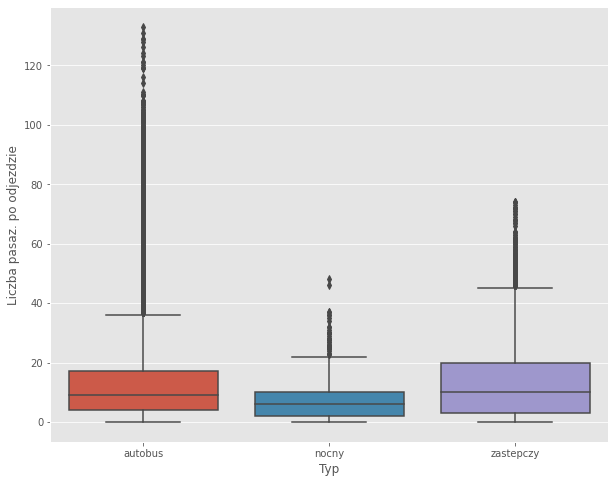

In [81]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    y='Liczba pasaz. po odjezdzie',
    x='Typ',
    data=df
)

<Figure size 432x288 with 0 Axes>

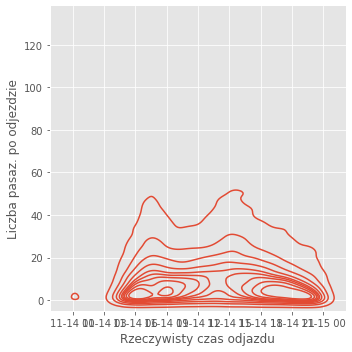

In [82]:
plt.figure()
ax = sns.displot(
    df,
    x='Rzeczywisty czas odjazdu',
    y='Liczba pasaz. po odjezdzie',
    kind='kde'
)

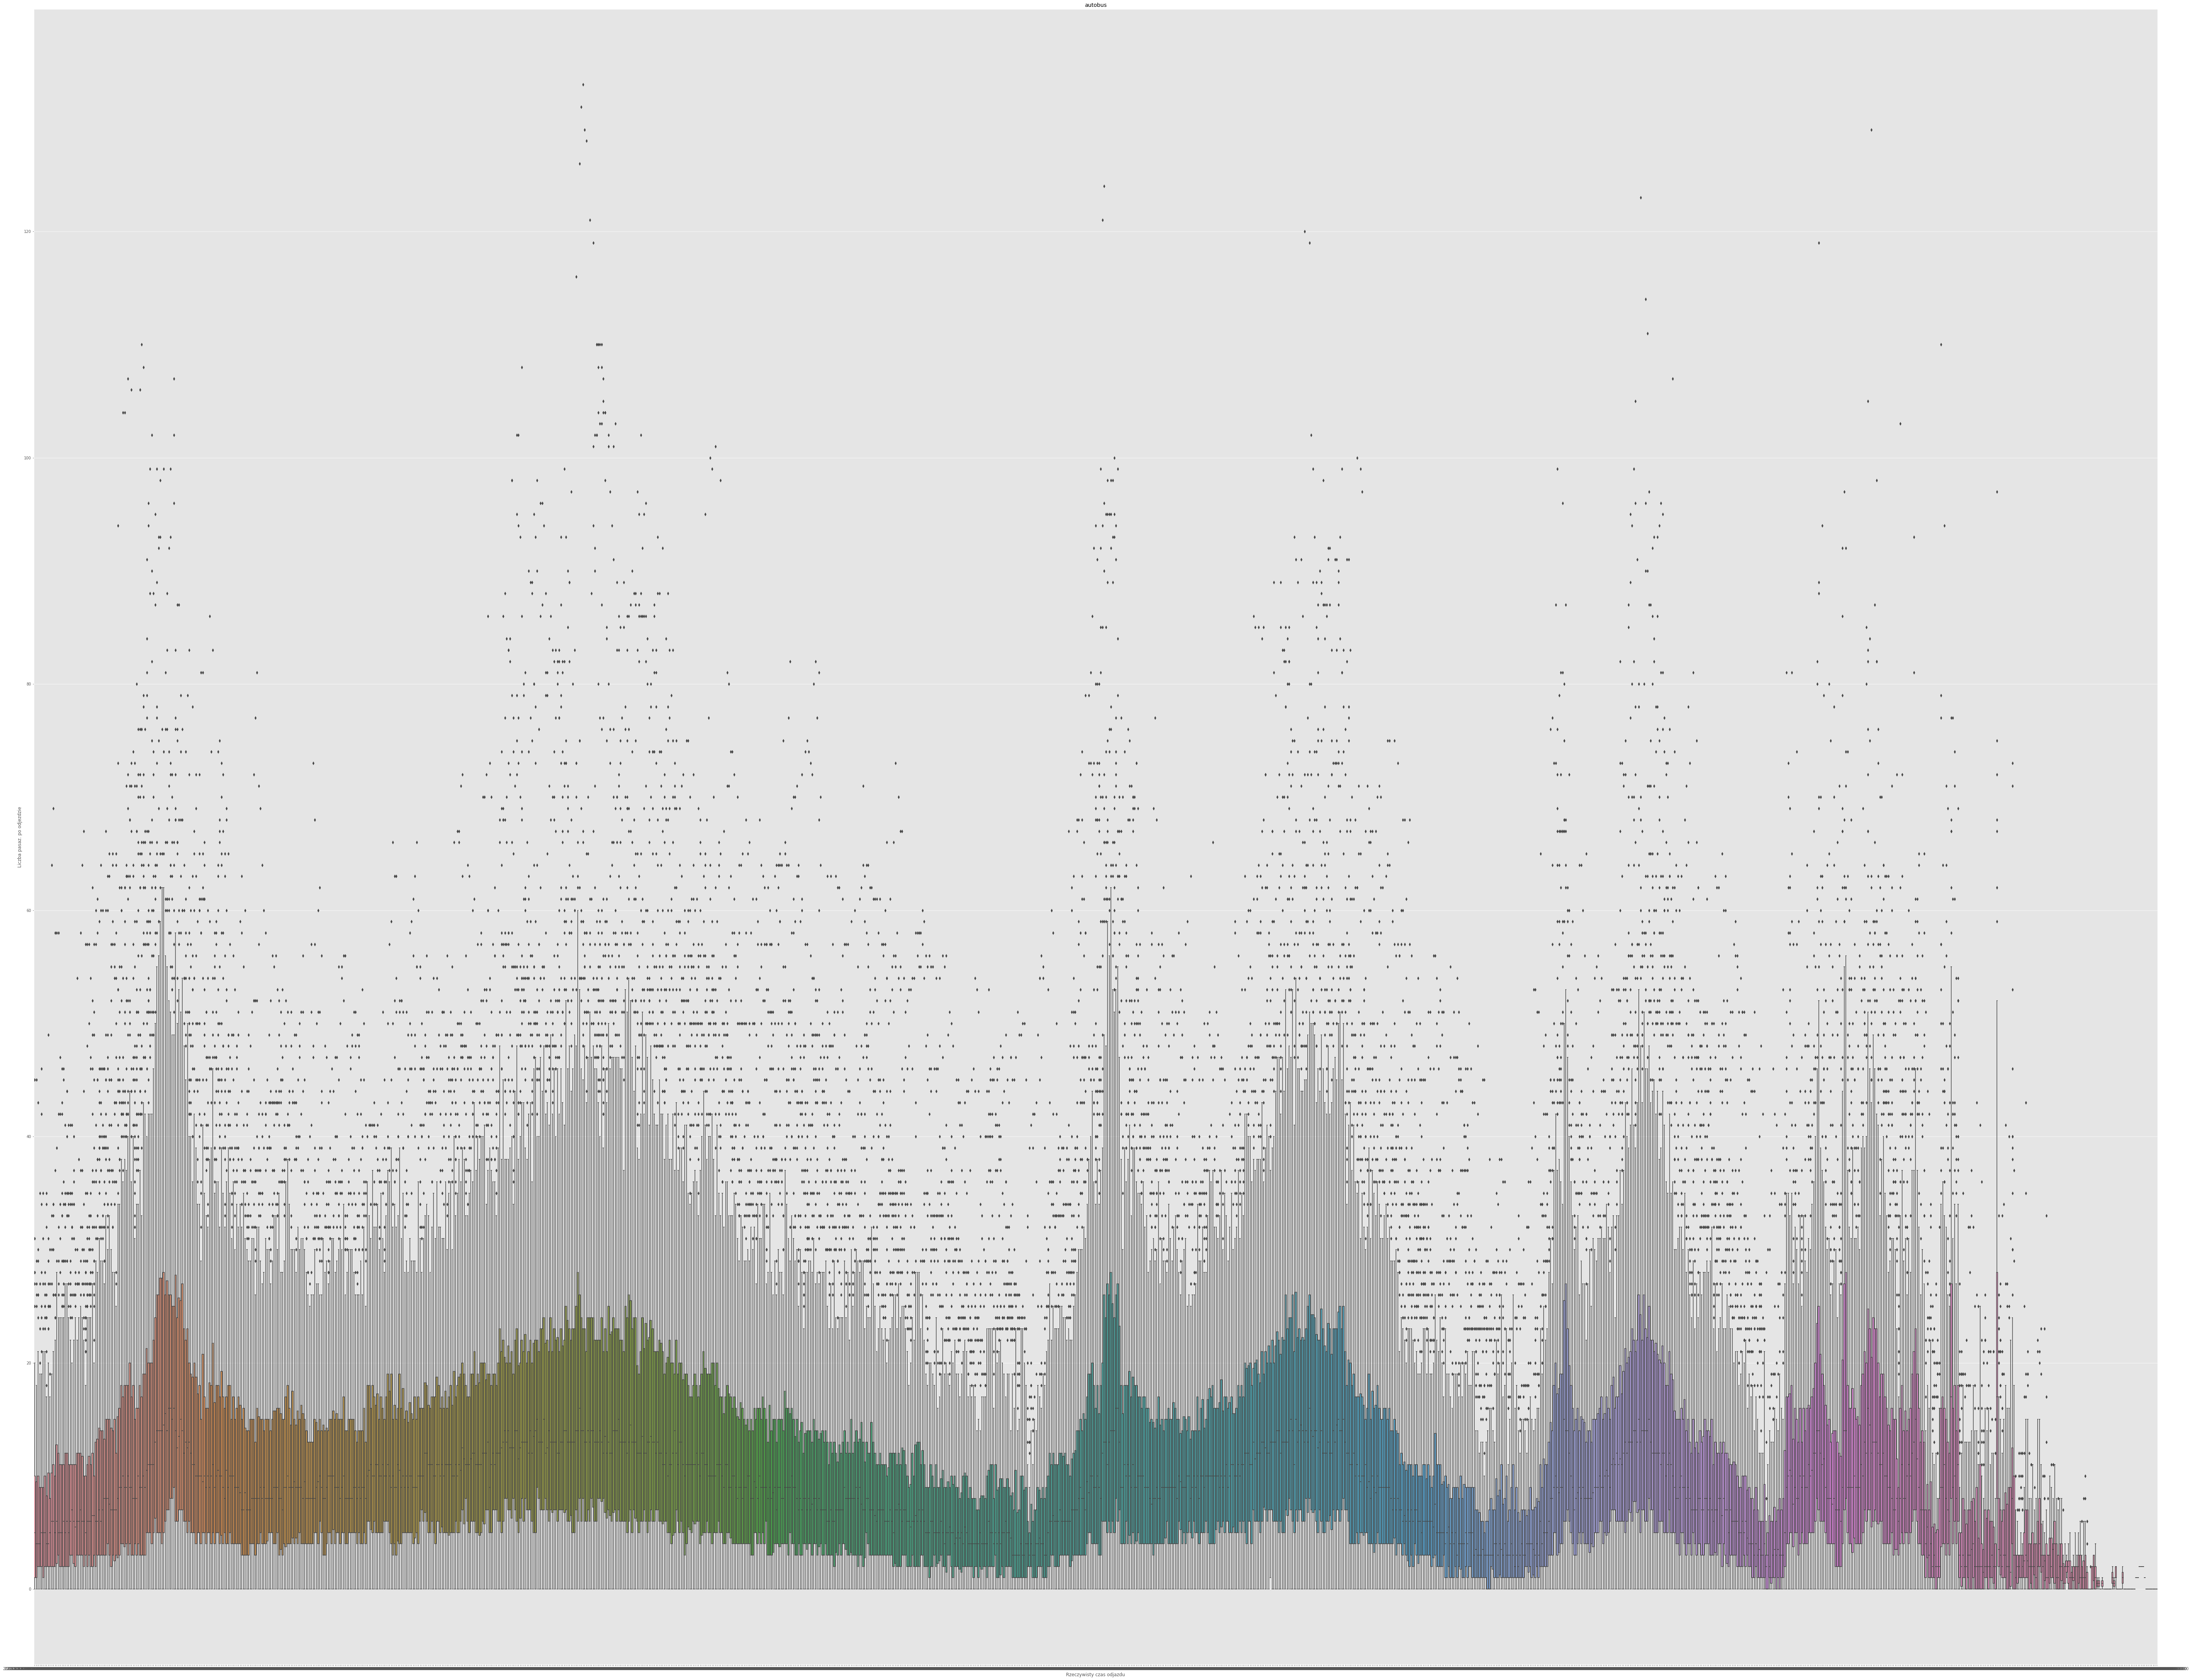

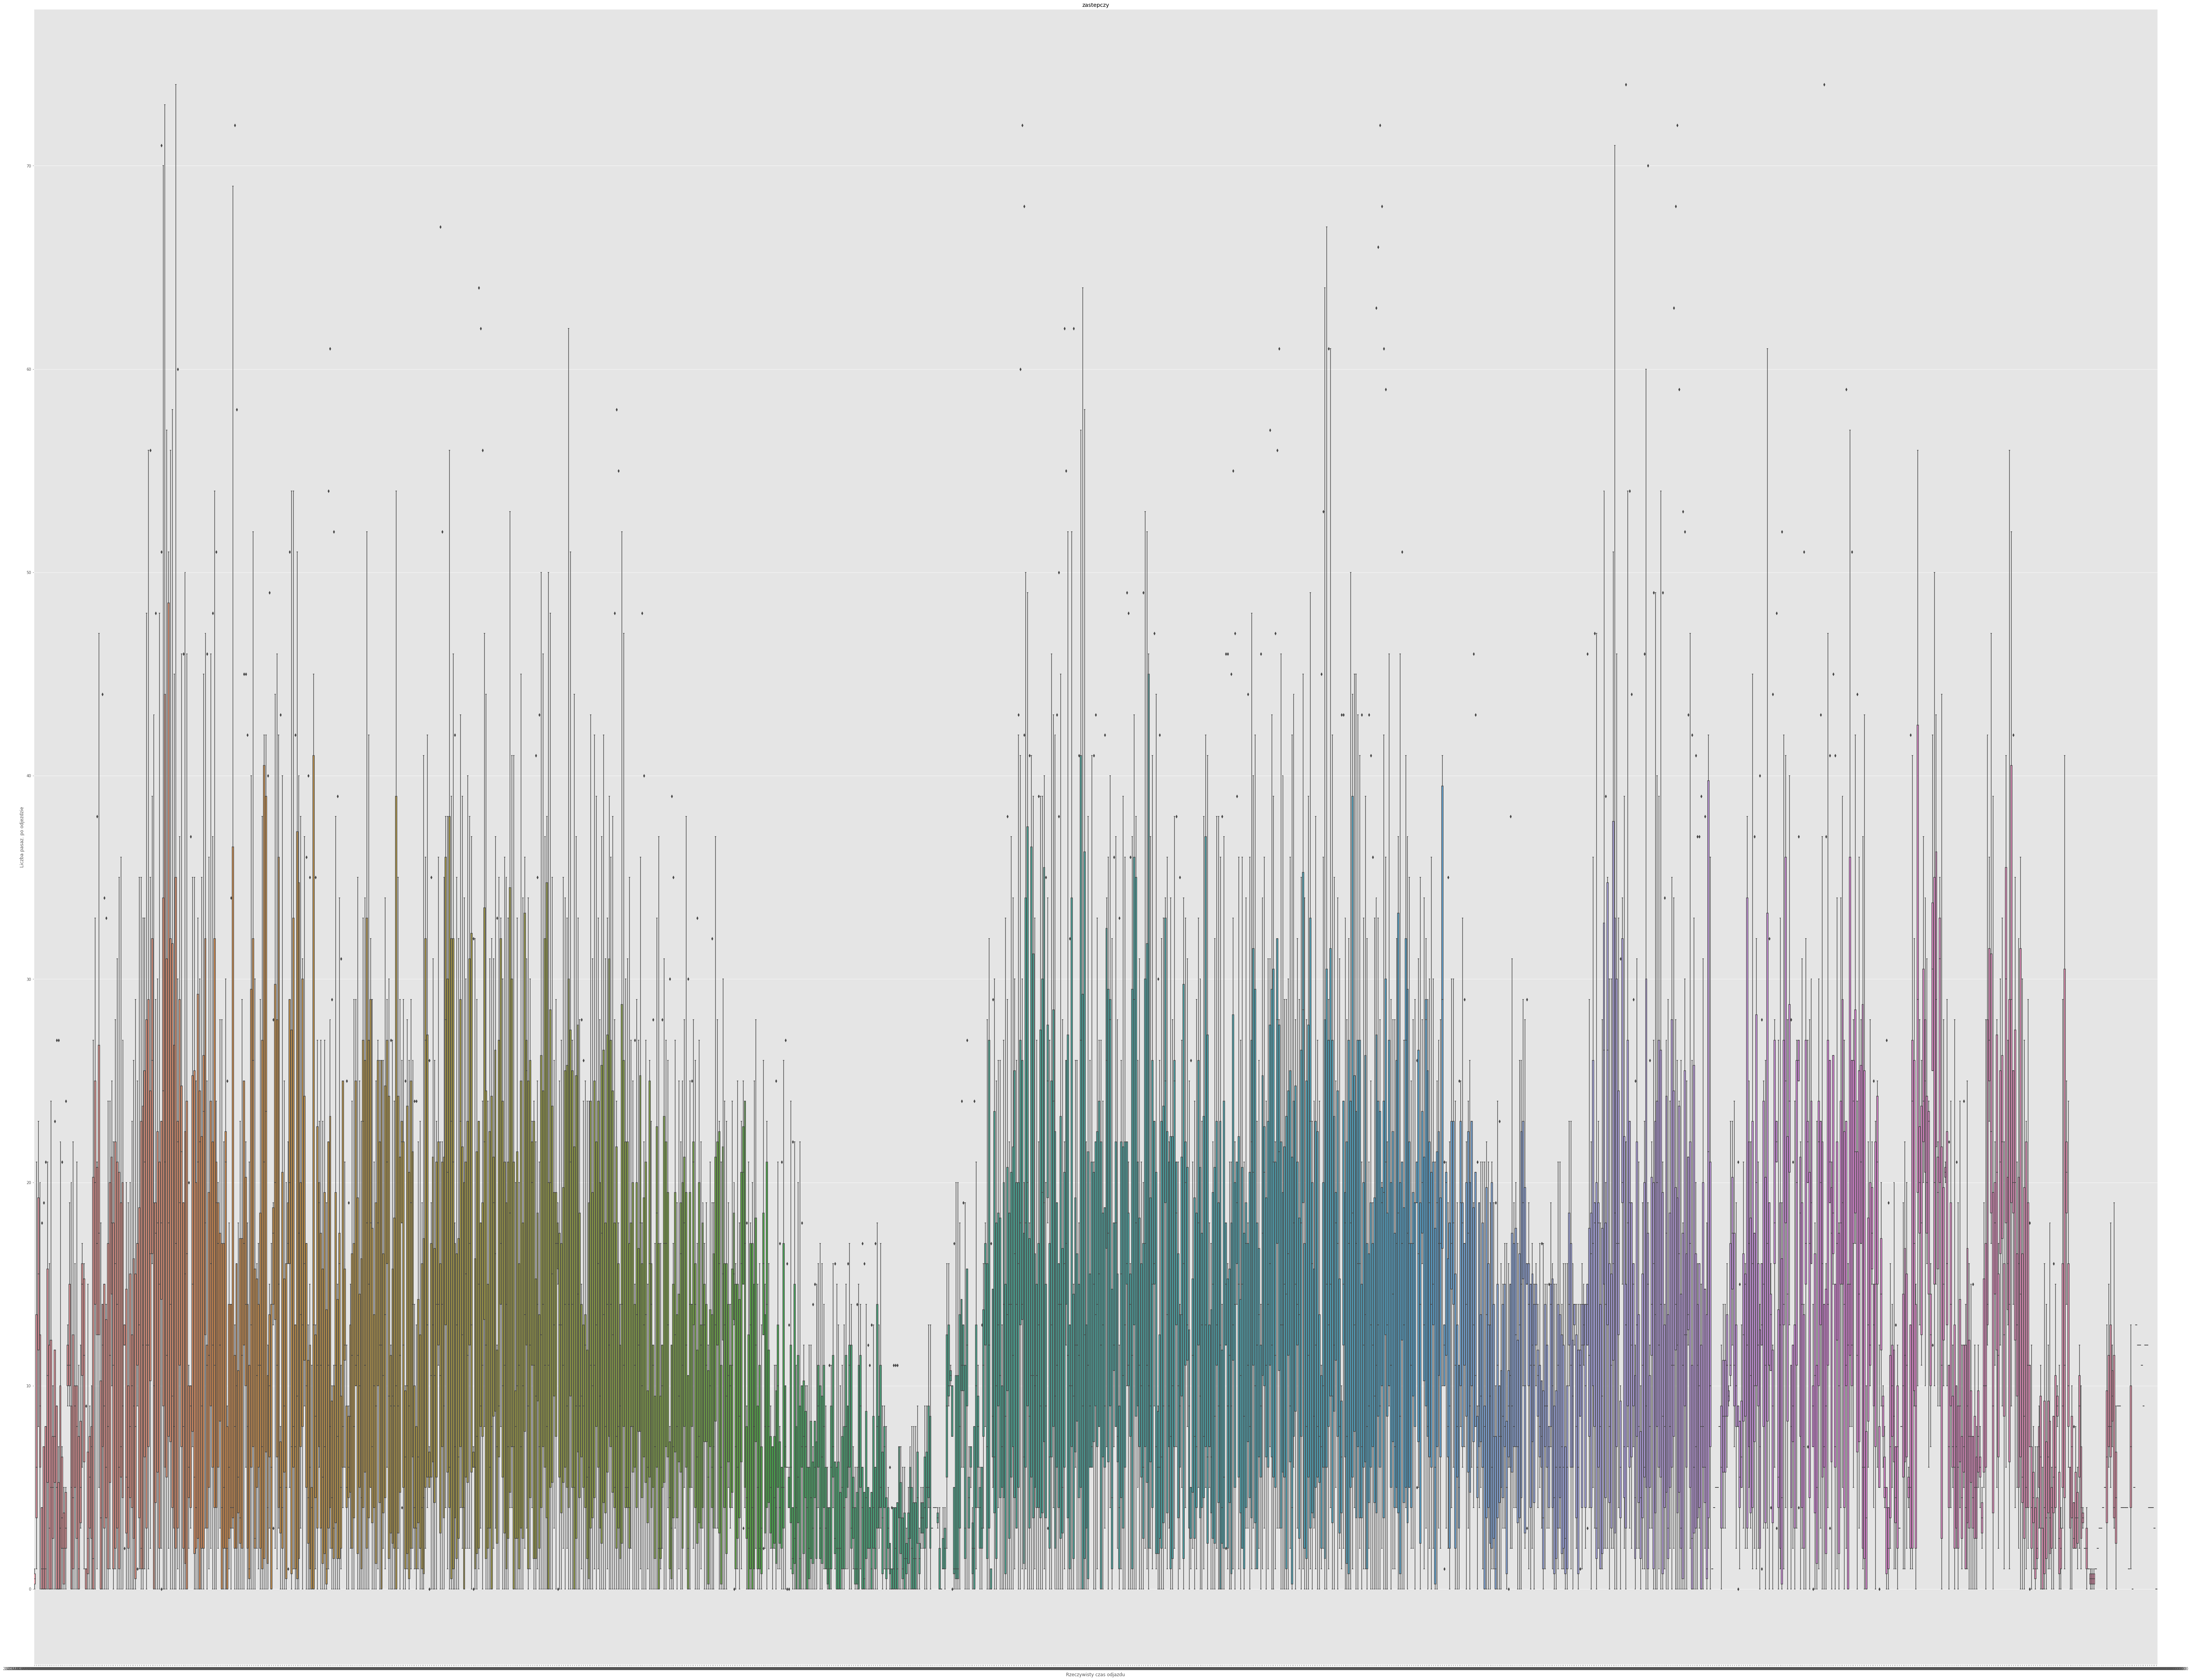

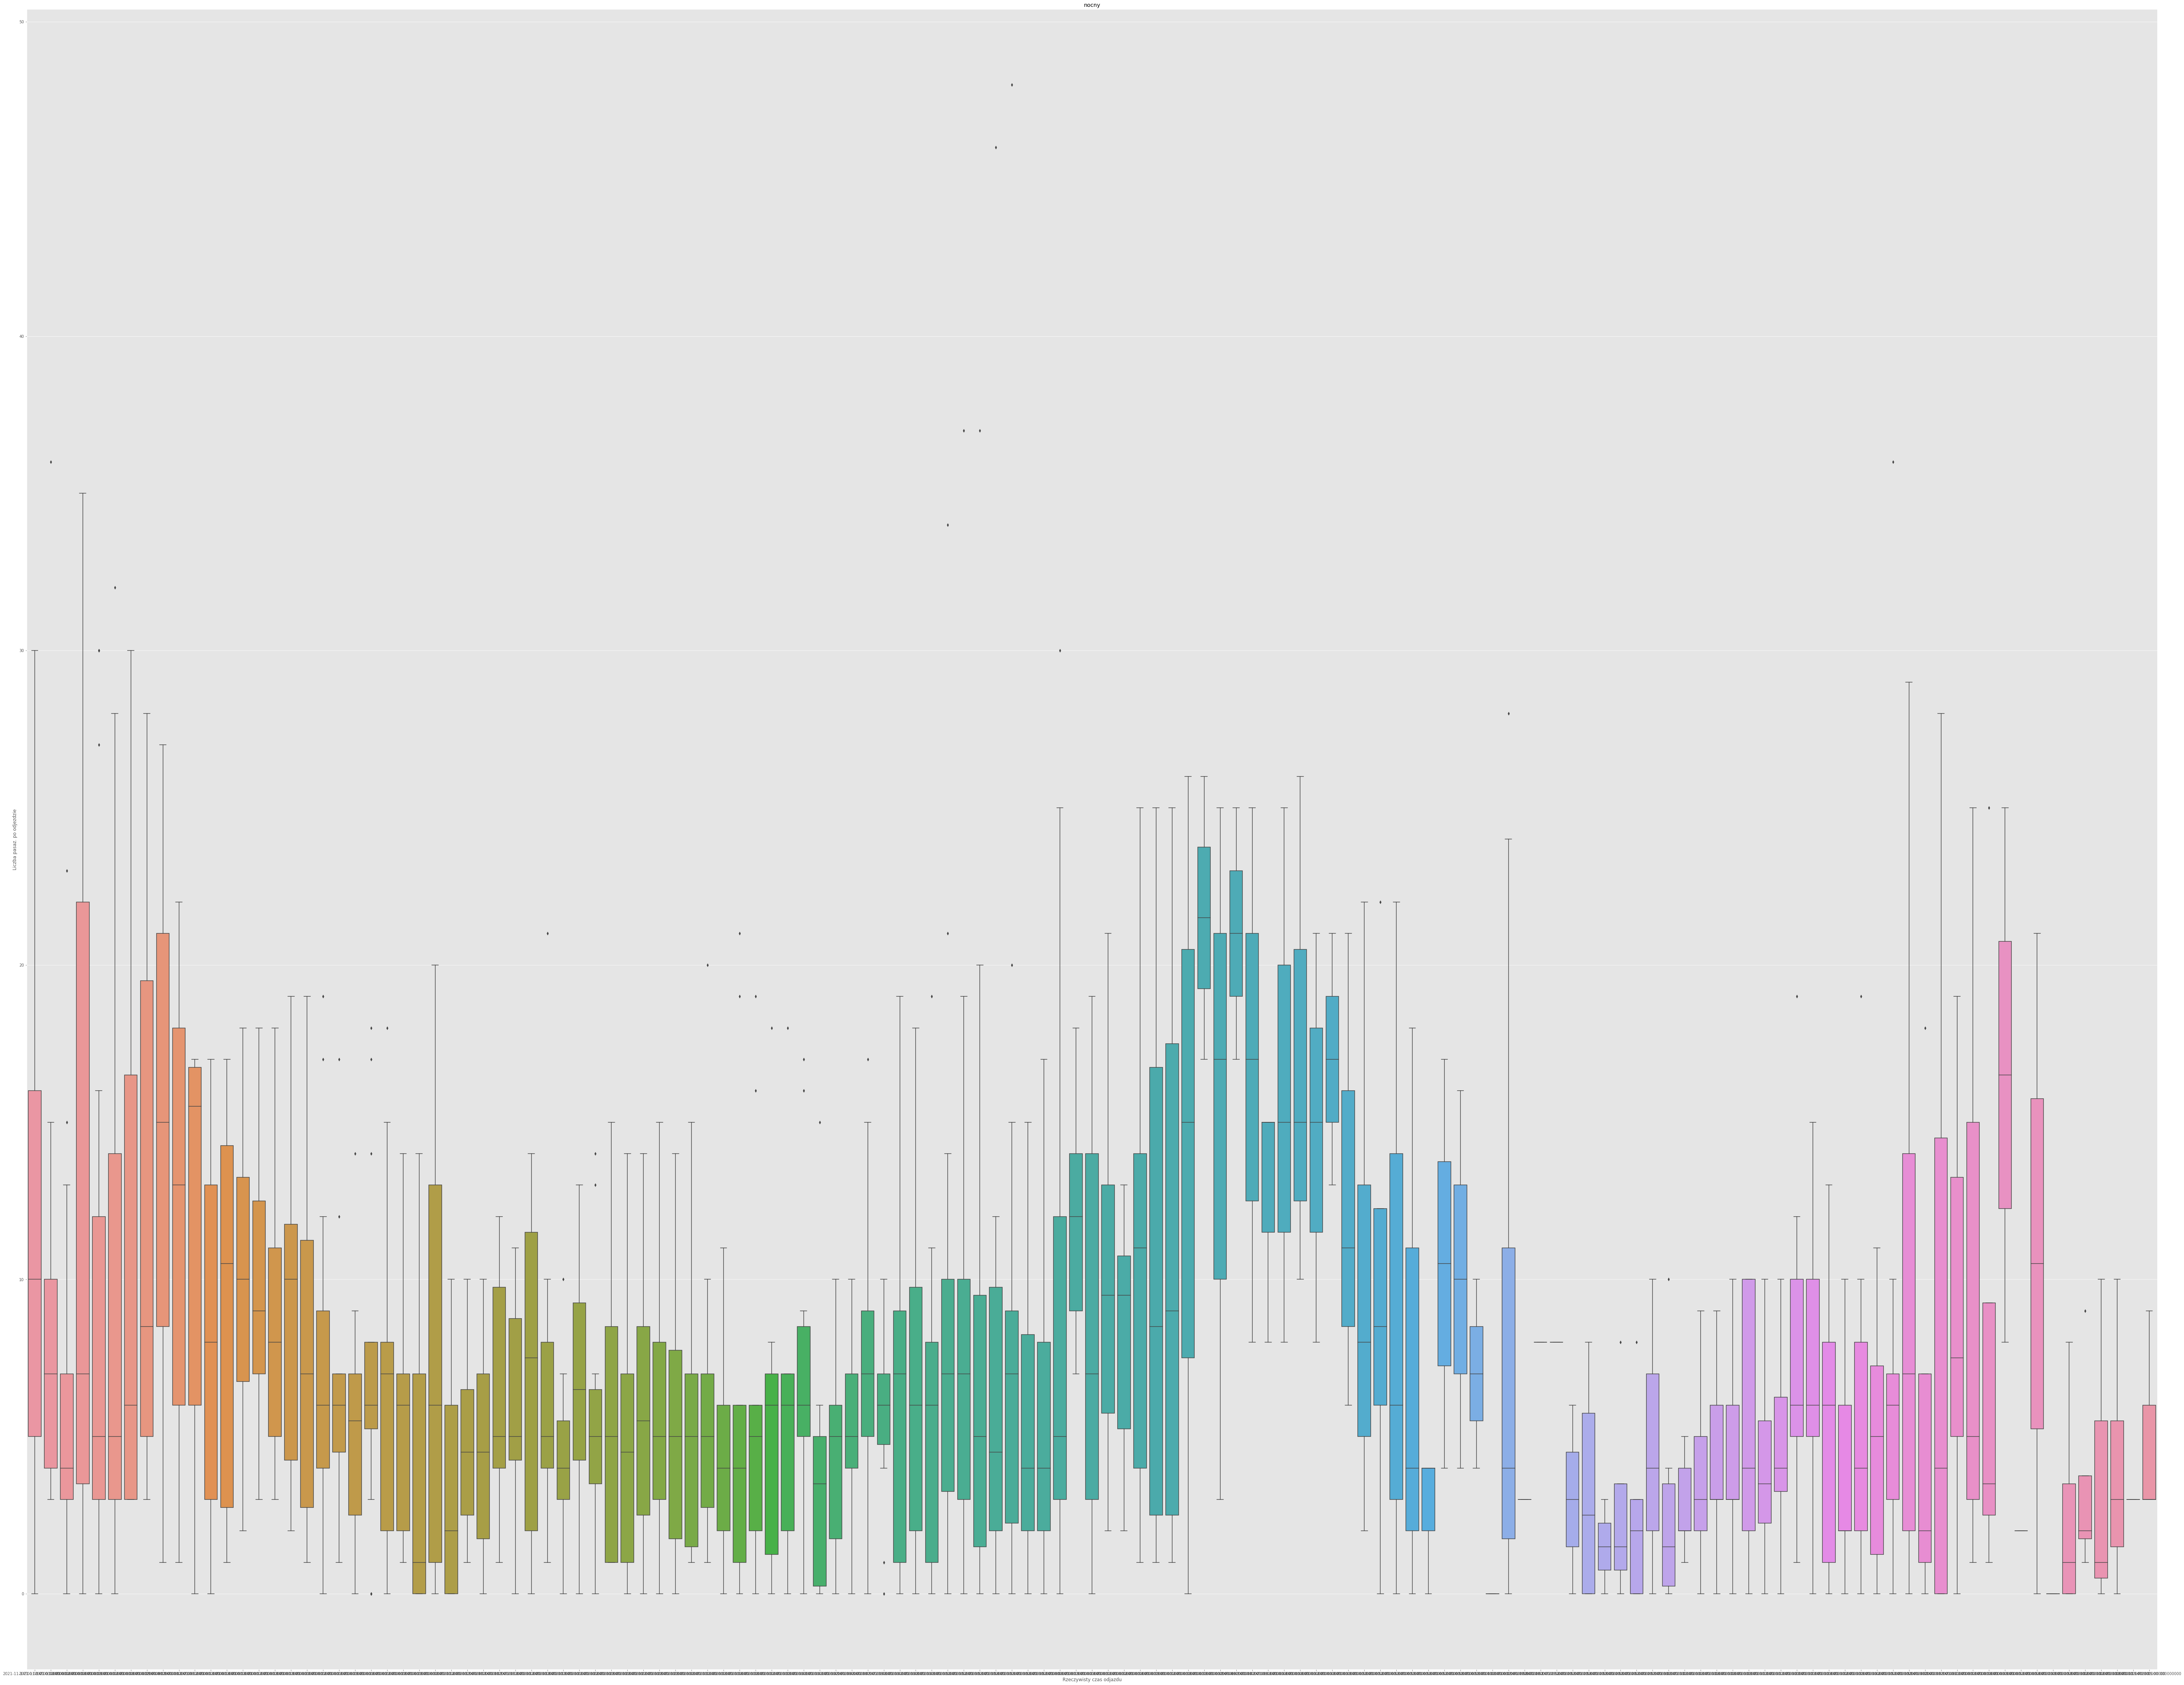

In [83]:
for trans_type in ['autobus', 'zastepczy', 'nocny']:
    plt.figure(figsize=(100, 80))
    ax = sns.boxplot(
        x='Rzeczywisty czas odjazdu',
        y='Liczba pasaz. po odjezdzie',
        data=df.loc[df['Typ']==trans_type]
    )
    ax.set_title(trans_type)

# 6. Clustering

In [84]:
def find_clusters(speeds, iterations, df, column):
    k = len(speeds)
    data = np.array(df[column]).reshape(1,-1).T
    clusters = KMeans(
        n_clusters = k,
        max_iter = iterations,
        random_state = RANDOM_SEED
    ).fit(data)
    
    cc, *_ = clusters.cluster_centers_.reshape(1,k)
    cc_ord = np.argsort(cc)
    class_mapping = dict(zip(cc_ord, speeds))
    
    df['class'] = clusters.labels_
    df['class'] = df['class'].map(class_mapping)
    
    return df

In [85]:
crowding = ['low', 'medium', 'high']
iterations = 10

df = find_clusters(crowding, iterations, df, 'Liczba pasaz. po odjezdzie')

<Figure size 720x576 with 0 Axes>

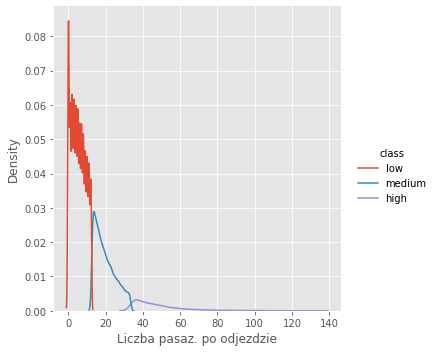

In [86]:
plt.figure(figsize=(10, 8))
ax = sns.displot(
    df,
    x='Liczba pasaz. po odjezdzie',
    hue='class',
    kind='kde'
)

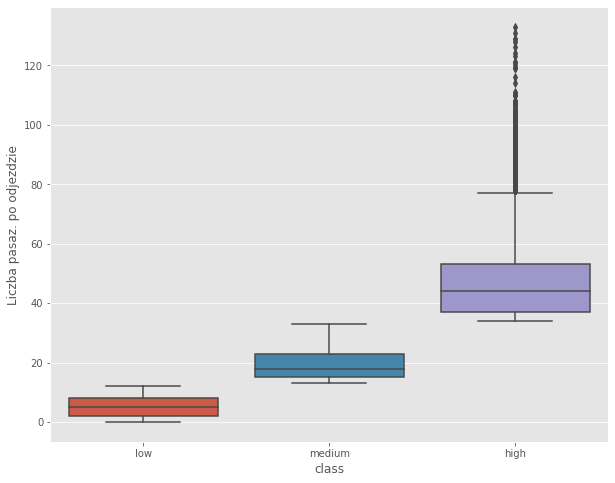

In [87]:
plt.figure(figsize=(10, 8))
ax = sns.boxplot(
    x='class',
    order=crowding,
    y='Liczba pasaz. po odjezdzie',
    data=df
)

# 5. Klasyfikacja wielomianowa (Polynomial Classifiers) - zle


In [88]:
from numpy import asarray
from sklearn.preprocessing import PolynomialFeatures

In [89]:

# define the dataset
data = asarray([[2,3],[2,3],[2,3]])
print(data)
# perform a polynomial features transform of the dataset
trans = PolynomialFeatures(degree=2)
data = trans.fit_transform(data)
print(data)

[[2 3]
 [2 3]
 [2 3]]
[[1. 2. 3. 4. 6. 9.]
 [1. 2. 3. 4. 6. 9.]
 [1. 2. 3. 4. 6. 9.]]


In [90]:
df.head(1)

,Nr linii,Wariant linii,Kurs,Oznaczenie brygady,Numer taborowy,Nazwa przystanku,Numer przystanku,Rzeczywisty czas odjazdu,Rozkładowy czas odjazdu,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie,Typ,class
0,102,TP-EMP,2021-11-14 05:11:00,1,9415,PKP Olszynka Grochowska,4,2021-11-14 05:11:00,2021-11-14 05:11:00,0,0,1,1,autobus,low


In [91]:
df_polfeat = df[['Numer taborowy','Numer przystanku','Liczba pasaz. przed','Liczba wysiadających pasaz.','Liczba wsiadajacych pasaz.','Liczba pasaz. po odjezdzie']]
df_polfeat.head(3)

,Numer taborowy,Numer przystanku,Liczba pasaz. przed,Liczba wysiadających pasaz.,Liczba wsiadajacych pasaz.,Liczba pasaz. po odjezdzie
0,9415,4,0,0,1,1
1,9415,3,1,0,0,1
2,9415,1,1,0,2,3


In [92]:
deg = len(df_polfeat.columns)
arr = np.array(df_polfeat)

In [93]:
polynomialFeatures = PolynomialFeatures(degree=deg)
output = polynomialFeatures.fit_transform(arr)
print(output)


[[1.000e+00 9.415e+03 4.000e+00 ... 1.000e+00 1.000e+00 1.000e+00]
 [1.000e+00 9.415e+03 3.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 9.415e+03 1.000e+00 ... 3.240e+02 4.860e+02 7.290e+02]
 ...
 [1.000e+00 9.946e+03 1.000e+00 ... 0.000e+00 0.000e+00 6.400e+01]
 [1.000e+00 9.946e+03 1.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
 [1.000e+00 9.946e+03 1.000e+01 ... 0.000e+00 0.000e+00 0.000e+00]]


In [94]:
uniq = np.unique(np.array(df['Nr linii']))
uniq

array(['102', '103', '104', '106', '118', '122', '123', '127', '131',
       '132', '134', '135', '138', '140', '142', '149', '152', '153',
       '157', '159', '161', '164', '176', '177', '179', '181', '184',
       '185', '186', '190', '193', '194', '197', '199', '201', '203',
       '204', '207', '208', '209', '210', '211', '212', '219', '220',
       '225', '234', '239', '249', '256', '262', '264', '304', '305',
       '314', '320', '323', '326', '332', '339', '516', '517', '520',
       '522', '525', '707', '710', '712', '715', '719', '724', '729',
       '737', '739', '742', '743', '809', '900', 'N01', 'N02', 'N03',
       'N14', 'N25', 'N41', 'N42', 'N43', 'N64', 'N71', 'N91', 'Z-2',
       'Z23'], dtype=object)

In [95]:
len(uniq)

91

# 7 Negative binomial regression attempt (NB2 model)

[Source](https://timeseriesreasoning.com/contents/negative-binomial-regression-model/)


In [117]:
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [118]:
df_nb2feat = df[['Liczba pasaz. po odjezdzie', 'Rzeczywisty czas odjazdu', 'Nr linii']]
ds = df['Rzeczywisty czas odjazdu']
df_nb2feat['Godzina'] = ds.dt.hour
df_nb2feat[['LiczbaPasazPoOdjezdzie', 'NrLinii']] = df[['Liczba pasaz. po odjezdzie', 'Nr linii']]
df_nb2feat.head(3)

/tmp/ipykernel_7146/2664382424.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nb2feat['Godzina'] = ds.dt.hour
/usr/local/lib/python3.9/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Liczba pasaz. po odjezdzie,Rzeczywisty czas odjazdu,Nr linii,Godzina,LiczbaPasazPoOdjezdzie,NrLinii
0,1,2021-11-14 05:11:00,102,5,1,102
1,1,2021-11-14 05:12:00,102,5,1,102
2,3,2021-11-14 05:13:00,102,5,3,102


In [119]:
mask = np.random.rand(len(df)) < 0.8
df_train = df_nb2feat[mask]
df_test = df_nb2feat[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=133740
Testing data set length=33602


## 7.1 Poisson Regression

In [120]:
len(df_train['Nr linii'])

133740

In [121]:
expr = """LiczbaPasazPoOdjezdzie ~ Godzina"""

y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

print(poisson_training_results.summary())

                   Generalized Linear Model Regression Results                    
Dep. Variable:     LiczbaPasazPoOdjezdzie   No. Observations:               133740
Model:                                GLM   Df Residuals:                   133738
Model Family:                     Poisson   Df Model:                            1
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -9.5779e+05
Date:                    Sun, 14 Nov 2021   Deviance:                   1.4168e+06
Time:                            16:03:51   Pearson chi2:                 1.67e+06
No. Iterations:                         5   Pseudo R-squ. (CS):            0.03913
Covariance Type:                nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

In [122]:
print(poisson_training_results.mu)
print(len(poisson_training_results.mu))

[13.33410219 13.33410219 13.33410219 ... 11.72567416 11.72567416
 11.72567416]
133740


In [123]:
df_train['BB_LAMBDA'] = poisson_training_results.mu

/tmp/ipykernel_7146/928414325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['BB_LAMBDA'] = poisson_training_results.mu


## 7.2 OLS Regression


In [125]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['LiczbaPasazPoOdjezdzie'] - x['BB_LAMBDA'])**2
                                                    - x['BB_LAMBDA']) / x['BB_LAMBDA'], axis=1)
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

aux_olsr_results.params

BB_LAMBDA    0.93903
dtype: float64


/tmp/ipykernel_7146/69869453.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['LiczbaPasazPoOdjezdzie'] - x['BB_LAMBDA'])**2


In [126]:
aux_olsr_results.tvalues

BB_LAMBDA    110.775626
dtype: float64

Check statistical significance of ^


## 7.3 NB2 model

In [127]:
nb2_training_results = sm.GLM(
    y_train,
    X_train,
    family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

nb2_training_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                   Generalized Linear Model Regression Results                    
==================================================================================
Dep. Variable:     LiczbaPasazPoOdjezdzie   No. Observations:               133740
Model:                                GLM   Df Residuals:                   133738
Model Family:            NegativeBinomial   Df Model:                            1
Link Function:                        Log   Scale:                          1.0000
Method:                              IRLS   Log-Likelihood:            -4.7340e+05
Date:                    Sun, 14 Nov 2021   Deviance:                   1.5089e+05
Time:                            16:08:28   Pearson chi2:                 1.34e+05
No. Iterations:                         8   Pseudo R-squ. (CS):           0.003877
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6740      0.007    361.538      0.000       2.660       2.689
Godzina       -0.0130      0.001    -25.123      0.000      -0.014      -0.012
==============================================================================
"""

## 7.4 Model predictions

In [128]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

predictions_summary_frame = nb2_predictions.summary_frame()
predictions_summary_frame

,mean,mean_se,mean_ci_lower,mean_ci_upper
5,13.585167,0.069119,13.450369,13.721316
11,13.585167,0.069119,13.450369,13.721316
12,13.585167,0.069119,13.450369,13.721316
15,13.585167,0.069119,13.450369,13.721316
16,13.585167,0.069119,13.450369,13.721316
...,...,...,...,...
177520,11.774146,0.036594,11.702640,11.846089
177521,11.774146,0.036594,11.702640,11.846089
177527,11.774146,0.036594,11.702640,11.846089
177535,11.774146,0.036594,11.702640,11.846089


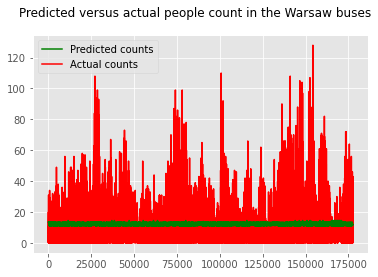

In [135]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['LiczbaPasazPoOdjezdzie']
fig = plt.figure()
fig.suptitle('Predicted versus actual people count in the Warsaw buses')
actual, = plt.plot(X_test.index, actual_counts, 'r-', label='Actual counts')
predicted, = plt.plot(X_test.index, predicted_counts, 'g-', label='Predicted counts')
plt.legend(handles=[predicted, actual])
plt.show()